# Second Notebook: Apply Manual Corrections & Display Discrepancy Results



At this point, the user/users should have gone through the file "manual_correction_to_make.csv" and made all manual corrections found therein. Thus, there should be no more "ERROR" messages within the values of the CSV file. 

This notebook exists for two purposes. First, it merges the manual corrections with DM-FS. Second, it displays statistics regarding the discrepancies that exists between the three crowdsourced databases (fe, mpv, wp)

# 0 | Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter # Unique value ID
import math
import os

# Ven Diagram
from matplotlib import pyplot as plt
from matplotlib_venn import venn3_unweighted

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1 | Loads & Cleans Manual Correction Dataframe

### 1.1 | Aux Functions

In [4]:
# Checks that there are no more ERROR messsages in corresponding columns
# Takes a Index of columns, e.g., df.columns

def check_that_errors_are_corrected(df, cols):
    print(f"Checking to make sure that there are no more ERROR messages in : {list(cols)}.")
    for ind_col in cols:
        if df[ind_col].astype(str).isin(["ERROR - 2 Databases Disagree", "ERROR - 3 Databases Disagree"]).any():
            print(f"{'-'*20}")
            print(f"ERROR. Column [{ind_col}] contains an ERROR value")
            return

    print(f"{'-'*20}")
    print("Congratulations. All columns contain a non-error value")

In [5]:
# Checks that all discrepancy columns have a true/false value. 
# Takes a Index of columns, e.g., df.columns
def check_that_discrepancies_are_corrected(df, cols):
    print(f"Checking to make sure that all discrepencies have been correctly identified, i.e., all values are True or False in the followign columns: {list(cols)}.")
    for ind_col in cols:
        if not (df[ind_col].astype(str).isin(['True', 'False']).all() ):
            print(f"{'-'*20}")
            print(f"ERROR. Column [{ind_col}] contains a non True/False value")
            return

    print(f"{'-'*20}")
    print("Congratulations. All discrepancy columns contain values that are either True or False")

### 1.2 | Loads Manual Corrections Dataset

In [6]:
# Imports master DF & Manual Corrections
DIR_MANUAL_CORRECTIONS = "res/1.2 - DM-FS Before Manual Corrections/"
manual_corrections = pd.read_csv(f"{DIR_MANUAL_CORRECTIONS}manual_corrections_completed.csv", index_col = 0)
manual_corrections.head(3)

,date,victim_name,victim_age,victim_gender,victim_race,city_of_death,state_of_death,agency_responsible_1,agency_responsible_2,agency_responsible_3,agency_responsible_4,agency_responsible_5,agency_responsible_6,URL_FE,URL_MPV,Final URL,Notes,Flag for Exclusion,date_fe,date_mpv,date_wp,city_fe,city_mpv,city_wp,gender_fe,gender_mpv,gender_wp,age_fe,age_mpv,age_wp,race_fe,race_mpv,race_wp,agency_responsible_fe,agency_responsible_mpv,agency_responsible_wp
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,12/30/2020 0:00,David Jacob Rigsby,39,Male,Unknown,Waverly,TN,Waverly Police Department,Humphreys County Sheriff's Office,NaN,NaN,NaN,NaN,https://www.newschannel5.com/news/tbi-investig...,NaN,https://tbinewsroom.com/2020/12/30/tbi-agents-...,NaN,,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,right,FALSE,wrong,FALSE,FALSE,FALSE
10,12/29/2020 0:00,Samuel Lazaro,18,Male,Unknown,Brooklyn,NY,City of New York Police Department,NaN,NaN,NaN,NaN,NaN,https://www.radio.com/1010wins/news/local/nypd...,NaN,https://www.dailymail.co.uk/news/article-90996...,NaN,,FALSE,FALSE,FALSE,right,FALSE,Wrong,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,right,FALSE,wrong,FALSE,FALSE,FALSE
19,12/28/2020 0:00,Not Disclosed,-1,Unknown,Unknown,Holyoke,CO,Holyoke Police Department,NaN,NaN,NaN,NaN,NaN,https://denver.cbslocal.com/2020/12/30/holyoke...,https://denver.cbslocal.com/2020/12/30/holyoke...,https://www.cbsnews.com/colorado/news/holyoke-...,NaN,,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,right,wrong,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


### 1.3 | Sanity Checks

In [7]:
# Ensures dates are properly coded
manual_corrections["date"] = pd.to_datetime(manual_corrections["date"], errors='coerce')

# Find the values that couldn't be converted (NaT values)
invalid_dates = manual_corrections[manual_corrections["date"].isna()]["date"]
if not invalid_dates.empty:
    print("ERROR. Invalid dates were inputted into manual corrections: ", invalid_dates)
    assert(False)

print("Assertion passed. There are no invalid dates. All dates were coded correctly.")

Assertion passed. There are no invalid dates. All dates were coded correctly.


In [8]:
# Checks to make sure there's no more error values
end_col = manual_corrections.columns.get_loc('URL_FE')
check_that_errors_are_corrected(manual_corrections, manual_corrections.columns[0 : end_col ])

Checking to make sure that there are no more ERROR messages in : ['date', 'victim_name', 'victim_age', 'victim_gender', 'victim_race', 'city_of_death', 'state_of_death', 'agency_responsible_1', 'agency_responsible_2', 'agency_responsible_3', 'agency_responsible_4', 'agency_responsible_5', 'agency_responsible_6'].
--------------------
Congratulations. All columns contain a non-error value


In [9]:
# The manual corrections DF did not use booleans to identify whether a database (MPV, WP, FE) was right or wrong: they instead used the string 'right' or 'wrong'
# Let's check to make sure all columns were coded properly

# Loops through every discrepency column
start_col = manual_corrections.columns.get_loc('date_fe')
for ind_col in manual_corrections.columns[start_col : manual_corrections.shape[1] ]:
    print("Checking column ", ind_col)

    # Converts to string, makes lowercase, removes extra spaces
    manual_corrections[ind_col] = manual_corrections[ind_col].astype(str).astype(str).str.strip().str.lower()

    # Loops through every value in that column
    for val_to_check in manual_corrections[ind_col]:
        if val_to_check != "true" and val_to_check != "false" and val_to_check != "right" and val_to_check != "wrong":
            print(f"--> Incorrectly coded value: [{val_to_check}]")
            assert(False)

print("Assertion passed. All discrepancy columns are either true, false, right, or wrong")

Checking column  date_fe
Checking column  date_mpv
Checking column  date_wp
Checking column  city_fe
Checking column  city_mpv
Checking column  city_wp
Checking column  gender_fe
Checking column  gender_mpv
Checking column  gender_wp
Checking column  age_fe
Checking column  age_mpv
Checking column  age_wp
Checking column  race_fe
Checking column  race_mpv
Checking column  race_wp
Checking column  agency_responsible_fe
Checking column  agency_responsible_mpv
Checking column  agency_responsible_wp
Assertion passed. All discrepancy columns are either true, false, right, or wrong


In [10]:
# Checks to see if any values are strange/abnormal. If so, corrects it.

print( manual_corrections["victim_gender"].value_counts() )
# Gender is OK

print( manual_corrections["victim_age"].value_counts() )
# Age is OK

print( manual_corrections["city_of_death"].value_counts() )
# City looks OK

victim_gender
Male           525
Female          25
Unknown          1
Transgender      1
Name: count, dtype: int64
victim_age
-1         26
32         22
27         20
30         20
29         20
39         19
35         19
34         19
31         18
25         18
28         17
36         16
37         15
26         15
18         13
41         12
24         12
56         12
49         12
40         12
51         11
45         11
21         11
38         11
33         10
46         10
19         10
43         10
23          9
48          9
47          9
50          9
22          8
17          7
53          7
57          6
63          6
42          6
55          6
59          5
58          5
20          5
44          5
54          3
65          2
70          2
52          2
60          2
Unknown     2
16          2
66          2
67          2
1           1
62          1
68          1
76          1
61          1
71          1
69          1
73          1
64          1
72          1
Name:

### 1.4 | Clean Dataframe

In [11]:
# Race needs to be corrected
print( manual_corrections["victim_race"].value_counts() )

print("\nRace after corrections")
manual_corrections["victim_race"] =  manual_corrections["victim_race"].replace({"Asian  " : "Asian & Pacific Islander", 
                                                                                "Afghanistan" : "Other"})
print( manual_corrections["victim_race"].value_counts() )

victim_race
White                       195
Unknown                     145
Black                        98
Hispanic                     96
Native American               7
Asian & Pacific Islander      5
Other                         4
Asian                         1
Afghanistan                   1
Name: count, dtype: int64

Race after corrections
victim_race
White                       195
Unknown                     145
Black                        98
Hispanic                     96
Native American               7
Asian & Pacific Islander      6
Other                         5
Name: count, dtype: int64


In [12]:

# Discrepancy columns: Records 'right' / 'false' strings to False (bool) and 'wrong' / 'true' strings to 'True'
# This is because a true value indicates a database is at fault, whereas a false value indicates there's no fault

# Loops through every discrepency column & applies this correction
start_col = manual_corrections.columns.get_loc('date_fe')
for ind_col in manual_corrections.columns[start_col : manual_corrections.shape[1] ]:
    manual_corrections[ind_col] = manual_corrections[ind_col].replace({"true" : True, "wrong" : True,
                                                                     "false" : False, "right" : False,})

# Verifies that all corrections have been applied, i.e., that all discrepancy columns are either True/False
check_that_discrepancies_are_corrected(manual_corrections, manual_corrections.columns[start_col : manual_corrections.shape[1] ] )

Checking to make sure that all discrepencies have been correctly identified, i.e., all values are True or False in the followign columns: ['date_fe', 'date_mpv', 'date_wp', 'city_fe', 'city_mpv', 'city_wp', 'gender_fe', 'gender_mpv', 'gender_wp', 'age_fe', 'age_mpv', 'age_wp', 'race_fe', 'race_mpv', 'race_wp', 'agency_responsible_fe', 'agency_responsible_mpv', 'agency_responsible_wp'].
--------------------
Congratulations. All discrepancy columns contain values that are either True or False


# 2 | Applies Manual Corrections to DM-FS

### 2.1 | Loads Dataset & Implements Corrections

In [13]:
# Imports
master_df = pd.read_csv(f"{DIR_MANUAL_CORRECTIONS}DMFS_no_manual_corrections.csv", index_col = 0)

# Deletes irrelevant columns
cols = master_df.columns
master_df.drop(columns = cols[ cols.get_loc("name_abr"): cols.get_loc("city_of_death_abr") + 1], inplace = True)

# Adds one col for manual correction & displays
master_df["URL_MANUAL_CORRECTION"] = None
master_df.head(5)

,date,victim_name,victim_age,victim_gender,victim_race,city_of_death,state_of_death,agency_responsible_1,agency_responsible_2,agency_responsible_3,agency_responsible_4,agency_responsible_5,agency_responsible_6,omission_fe,omission_mpv,omission_wp,date_fe,date_mpv,date_wp,city_fe,city_mpv,city_wp,gender_fe,gender_mpv,gender_wp,age_fe,age_mpv,age_wp,race_fe,race_mpv,race_wp,agency_responsible_fe,agency_responsible_mpv,agency_responsible_wp,date_discrepancy_days,URL_FE,URL_MPV,URL_MANUAL_CORRECTION
0,2020-12-31 00:00:00,David Randall Shephard,39,Male,White,Beaumont,TX,Beaumont Police Department,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,https://www.12newsnow.com/article/news/local/s...,https://www.usnews.com/news/best-states/texas/...,None
1,2020-12-31 00:00:00,Rodolfo Caraballo Moreno,-1,Male,Hispanic,Miami,FL,Miami Police Department,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,https://www.local10.com/news/local/2021/01/01/...,https://www.local10.com/news/local/2021/01/01/...,None
2,2020-12-30 00:00:00,Christian Joseph Hall,19,Male,Asian & Pacific Islander,Stroudsburg,PA,Pennsylvania State Police,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0,https://www.mcall.com/news/local/mc-nws-hamilt...,https://www.mcall.com/news/local/mc-nws-hamilt...,None
3,2020-12-30 00:00:00,David Jacob Rigsby,39,Male,ERROR - 2 Databases Disagree,Waverly,TN,Waverly Police Department,Humphreys County Sheriff's Office,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,Unknown,False,White,False,False,False,0,https://www.newschannel5.com/news/tbi-investig...,NaN,None
4,2020-12-30 00:00:00,Dolal Idd,23,Male,Black,Minneapolis,MN,Minneapolis Police Department,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,https://kstp.com/news/felony-suspect-shot-kill...,https://kstp.com/news/felony-suspect-shot-kill...,None


In [14]:
# Gets columns to replace
correction_cols = manual_corrections.columns 
agency_columns = correction_cols[correction_cols.get_loc("date"): correction_cols.get_loc("agency_responsible_6") + 1]
discrepancy_columns = correction_cols[correction_cols.get_loc("date_fe") : correction_cols.get_loc("agency_responsible_wp") +1 ]
print(f"Replacing the following columns for agency = {agency_columns}\n\ndiscrepancy={discrepancy_columns}")

Replacing the following columns for agency = Index(['date', 'victim_name', 'victim_age', 'victim_gender', 'victim_race',
       'city_of_death', 'state_of_death', 'agency_responsible_1',
       'agency_responsible_2', 'agency_responsible_3', 'agency_responsible_4',
       'agency_responsible_5', 'agency_responsible_6'],
      dtype='object')

discrepancy=Index(['date_fe', 'date_mpv', 'date_wp', 'city_fe', 'city_mpv', 'city_wp',
       'gender_fe', 'gender_mpv', 'gender_wp', 'age_fe', 'age_mpv', 'age_wp',
       'race_fe', 'race_mpv', 'race_wp', 'agency_responsible_fe',
       'agency_responsible_mpv', 'agency_responsible_wp'],
      dtype='object')


In [15]:
# Loops thorugh every index of 'manual_corrections'. Locates it in master_df, and once it's located, all relevant columns from master_df are replaced with
# those in manual_corrections (i.e., agency_columns and discrepancy_columns.
for index in tqdm(manual_corrections.index):
    if index in master_df.index:
        master_df.loc[index, "URL_MANUAL_CORRECTION"] = manual_corrections.loc[index, "Final URL"]
        for col_to_replace in ( list(agency_columns) + list(discrepancy_columns) ):
            master_df.loc[index, col_to_replace] = manual_corrections.loc[index, col_to_replace]
    else:
        print(f"ERROR. Index {index} from manual_corrections not found in master_df. Thus, the manual corrections cannot be applied. This should never happen")
        assert(False)

100%|███████████████████████████████████████████████████████████████████████████████| 552/552 [00:03<00:00, 163.27it/s]


In [17]:
master_df.head(4)

,date,victim_name,victim_age,victim_gender,victim_race,city_of_death,state_of_death,agency_responsible_1,agency_responsible_2,agency_responsible_3,agency_responsible_4,agency_responsible_5,agency_responsible_6,omission_fe,omission_mpv,omission_wp,date_fe,date_mpv,date_wp,city_fe,city_mpv,city_wp,gender_fe,gender_mpv,gender_wp,age_fe,age_mpv,age_wp,race_fe,race_mpv,race_wp,agency_responsible_fe,agency_responsible_mpv,agency_responsible_wp,date_discrepancy_days,URL_FE,URL_MPV,URL_MANUAL_CORRECTION
0,2020-12-31 00:00:00,David Randall Shephard,39,Male,White,Beaumont,TX,Beaumont Police Department,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,https://www.12newsnow.com/article/news/local/s...,https://www.usnews.com/news/best-states/texas/...,None
1,2020-12-31 00:00:00,Rodolfo Caraballo Moreno,-1,Male,Hispanic,Miami,FL,Miami Police Department,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,https://www.local10.com/news/local/2021/01/01/...,https://www.local10.com/news/local/2021/01/01/...,None
2,2020-12-30 00:00:00,Christian Joseph Hall,19,Male,Asian & Pacific Islander,Stroudsburg,PA,Pennsylvania State Police,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0,https://www.mcall.com/news/local/mc-nws-hamilt...,https://www.mcall.com/news/local/mc-nws-hamilt...,None
3,2020-12-30 00:00:00,David Jacob Rigsby,39,Male,Unknown,Waverly,TN,Waverly Police Department,Humphreys County Sheriff's Office,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0,https://www.newschannel5.com/news/tbi-investig...,NaN,https://tbinewsroom.com/2020/12/30/tbi-agents-...


### 2.2 | Sanity Checks

In [18]:
# Checks that there are no more ERROR messages
check_that_errors_are_corrected(master_df, agency_columns)

Checking to make sure that there are no more ERROR messages in : ['date', 'victim_name', 'victim_age', 'victim_gender', 'victim_race', 'city_of_death', 'state_of_death', 'agency_responsible_1', 'agency_responsible_2', 'agency_responsible_3', 'agency_responsible_4', 'agency_responsible_5', 'agency_responsible_6'].
--------------------
Congratulations. All columns contain a non-error value


In [19]:
# Checks that all discrapencies are assigned to a specific database
check_that_discrepancies_are_corrected(master_df, discrepancy_columns)

Checking to make sure that all discrepencies have been correctly identified, i.e., all values are True or False in the followign columns: ['date_fe', 'date_mpv', 'date_wp', 'city_fe', 'city_mpv', 'city_wp', 'gender_fe', 'gender_mpv', 'gender_wp', 'age_fe', 'age_mpv', 'age_wp', 'race_fe', 'race_mpv', 'race_wp', 'agency_responsible_fe', 'agency_responsible_mpv', 'agency_responsible_wp'].
--------------------
Congratulations. All discrepancy columns contain values that are either True or False


# 3 | Display Discrepancy Results

### 3.1 | Aux Functions

In [20]:
# Takes a series e.g., df['race'] and displays the values alongside counts

def display_count_alongside_percentage(display_series, title):
    print(title)
    value_counts = display_series.value_counts()
    total_count = value_counts.sum()
    for index, count in value_counts.items():
        percentage = round( (count / total_count) * 100, 2)
        print(f"{index} = {count} ({percentage:.2f}%)")
    print(f"{'-'*20}")
    print("Total = ",total_count)

###  3.2 | Discrepancies

In [21]:
for ind_discrepancy in ["omission", "date", "city", "gender", "age", "race", "agency_responsible", ]:
    print(f"Discrepancies for [{ind_discrepancy}] for fe, mpv, and wp:")
    grand_total = 0
    for db in ["fe", "mpv", "wp"]:
        vals = master_df[f"{ind_discrepancy}_{db}"].astype(str).value_counts()
        total_count = vals.sum()
        for index, count in vals.items():
            grand_total += count if index != 'False' else 0
            percentage = (count / total_count) * 100
            print(f"{index} = {count} ({percentage:.2f}%)")
        print(f"{'-'*20}")
    print(f"TOTAL = {grand_total}\n")

Discrepancies for [omission] for fe, mpv, and wp:
False = 6590 (92.75%)
True = 515 (7.25%)
--------------------
False = 6063 (85.33%)
True = 1042 (14.67%)
--------------------
False = 5946 (83.69%)
True = 1159 (16.31%)
--------------------
TOTAL = 2716

Discrepancies for [date] for fe, mpv, and wp:
False = 6971 (98.11%)
True = 134 (1.89%)
--------------------
False = 7069 (99.49%)
True = 36 (0.51%)
--------------------
False = 6873 (96.73%)
True = 232 (3.27%)
--------------------
TOTAL = 402

Discrepancies for [city] for fe, mpv, and wp:
False = 6988 (98.35%)
True = 117 (1.65%)
--------------------
False = 6855 (96.48%)
True = 250 (3.52%)
--------------------
False = 6198 (87.23%)
True = 907 (12.77%)
--------------------
TOTAL = 1274

Discrepancies for [gender] for fe, mpv, and wp:
False = 7098 (99.90%)
True = 7 (0.10%)
--------------------
False = 7102 (99.96%)
True = 3 (0.04%)
--------------------
False = 7097 (99.89%)
True = 8 (0.11%)
--------------------
TOTAL = 18

Discrepancies f

### 3.3 | Visualize & Handle Omissions

Omissions is a tough word to use. Namely, a database was flagged as having an omission if it didn't incldue a particular fatal shooting. However, WP, MPV, and FE have different inclusion criteria, so it may not really be a omission... it may be an intentional choice to not include a shooting.

Thus, let's change how we look at a fatal shooting. Let's look at the fatal shootings that are unique and/or shared between the three databases.

In [22]:
# Swaps true/false values such that it's now True if a civillian is included in a database (c.f., 'True' if it's an omission)
master_df['omission_fe'] = ~master_df['omission_fe'] 
master_df['omission_mpv'] = ~master_df['omission_mpv']
master_df['omission_wp'] = ~master_df['omission_wp']

# Renames columns to make them more intuitive
master_df.rename(columns={'omission_fe': 'included_in_fe', 
                          'omission_mpv': 'included_in_mpv',  
                          'omission_wp': 'included_in_wp'
                         }, inplace=True)

C:\Users\jjver\OneDrive\Cambridge\MPhil Dissertation\Publication\3. Scientific Data\DM-FS - Full v2.0\dmfs_python_virtual_environment\lib\site-packages\matplotlib_venn\_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


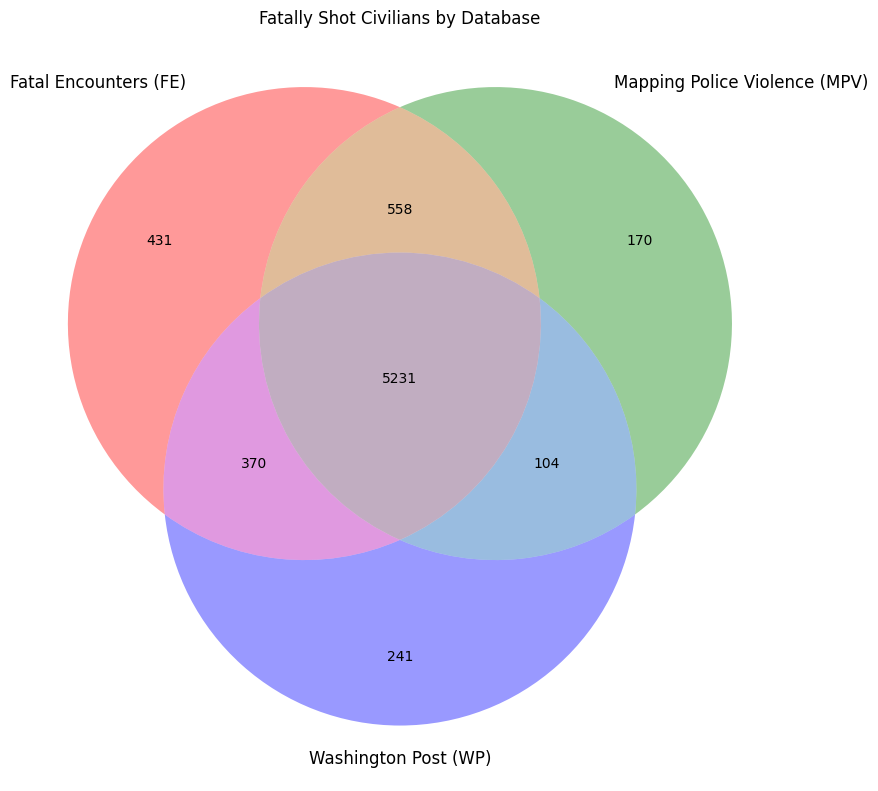

In [23]:
# Shortens names slightly
fe_true = master_df['included_in_fe'] 
mpv_true = master_df['included_in_mpv']
wp_true = master_df['included_in_wp']

# Create Ven Diagram via 3 sets of boolean indices
set1 = fe_true & ~mpv_true & ~wp_true   # FE Only: Fatally Shot Civilians that are ONLY in FE
set2 = ~fe_true & mpv_true & ~wp_true   # MPV Only
set3 = ~fe_true & ~mpv_true & wp_true   # WP Only
set12 = fe_true & mpv_true & ~wp_true   # FE & MPV Only
set13 = fe_true & ~mpv_true & wp_true   # FE & WP Only
set23 = ~fe_true & mpv_true & wp_true   # MPV & WP Only
set123 = fe_true & mpv_true & wp_true   # All 3 Databases

# Define the sizes of the circles for the Venn diagram
venn_counts = {
    '100': set1.sum(),    # FE Only
    '010': set2.sum(),    # MPV Only
    '001': set3.sum(),    # WP Only
    '110': set12.sum(),   # FE & MPV
    '101': set13.sum(),   # FE & WP
    '011': set23.sum(),   # MPV & WP
    '111': set123.sum()   # All 3 databases
}

# Plot the Venn diagram
plt.figure(figsize=(10, 10))
venn = venn3_unweighted(subsets=venn_counts, set_labels=('Fatal Encounters (FE)', 'Mapping Police Violence (MPV)', 'Washington Post (WP)'))

plt.title("Fatally Shot Civilians by Database")
plt.show()

# 4 | Export

In [24]:
# Resets indices to ensure they're clean
master_df = master_df.reset_index(drop=True)

In [25]:
# Define & Create export path
DIR_EXPORT = "res/2.0 - DM-FS with Manual Corrections/"
if not os.path.exists(DIR_EXPORT):
    os.makedirs(DIR_EXPORT)

In [26]:
master_df.to_csv(f"{DIR_EXPORT}DM-FS with Manual Corrections.csv", index = False)